# Linear Regression

## Agenda

1. Introducing the bikeshare dataset
    - Reading in the data
    - Visualizing the data
2. Linear regression basics
    - Form of linear regression
    - Building a linear regression model
    - Using the model for prediction
    - Does the scale of the features matter?
3. Working with multiple features
    - Visualizing the data (part 2)
    - Adding more features to the model
4. Choosing between models
    - Feature selection
    - Evaluation metrics for regression problems
    - Comparing models with train/test split and RMSE
    - Comparing testing RMSE with null RMSE
5. Creating features
    - Handling categorical features
    - Feature engineering
6. Comparing linear regression with other models

## Reading in the data

We'll be working with a dataset from Capital Bikeshare that was used in a Kaggle competition ([data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)).

In [189]:
# read the data and set the datetime as the index
import pandas as pd
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/bikeshare.csv'
bikes = pd.read_csv(url, index_col='datetime', parse_dates=True)

In [190]:
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1


**Questions:**

- What does each observation represent?
- What is the response variable (as defined by Kaggle)?
- How many features are there?

In [191]:
# "count" is a method, so it's best to name that column something else
bikes.rename(columns={'count':'total'}, inplace=True)

## Visualizing the data

In [8]:
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

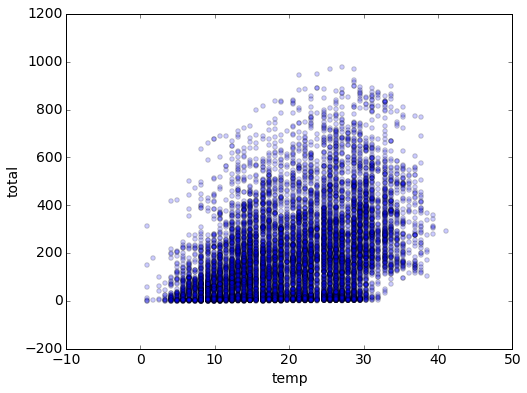

In [192]:
# Pandas scatter plot
bikes.plot(kind='scatter', x='temp', y='total', alpha=0.2)

In [10]:
# Seaborn scatter plot with regression line
sns.lmplot(x='temp', y='total', data=bikes, aspect=1.5, scatter_kws={'alpha':0.2})

NameError: name 'sns' is not defined

## Form of linear regression

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$

- $y$ is the response
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for $x_1$ (the first feature)
- $\beta_n$ is the coefficient for $x_n$ (the nth feature)

The $\beta$ values are called the **model coefficients**:

- These values are estimated (or "learned") during the model fitting process using the **least squares criterion**.
- Specifically, we are find the line (mathematically) which minimizes the **sum of squared residuals** (or "sum of squared errors").
- And once we've learned these coefficients, we can use the model to predict the response.

![Estimating coefficients](images/estimating_coefficients.png)

In the diagram above:

- The black dots are the **observed values** of x and y.
- The blue line is our **least squares line**.
- The red lines are the **residuals**, which are the vertical distances between the observed values and the least squares line.

## Building a linear regression model

In [193]:
# create X and y
feature_cols = ['temp']
X = bikes[feature_cols]
y = bikes.total

## scikit-learn's 4-step modeling pattern

**Step 1:** Import the class you plan to use

In [194]:
# import
from sklearn.linear_model import LinearRegression

**Step 2:** "Instantiate" the "estimator"

- "Estimator" is scikit-learn's term for "model"
- "Instantiate" means "make an instance of"

In [195]:
# make an instance of a LinearRegression object
linreg = LinearRegression()
type(linreg)

sklearn.linear_model.base.LinearRegression

- Created an object that "knows" how to do Linear Regression, and is just waiting for data
- Name of the object does not matter
- Can specify tuning parameters (aka "hyperparameters") during this step
- All parameters not specified are set to their defaults

In [197]:
print linreg

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


**Step 3:** Fit the model with data (aka "model training")

- Model is "learning" the relationship between X and y in our "training data"
- Process through which learning occurs varies by model
- Occurs in-place

In [196]:
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

- Once a model has been fit with data, it's called a "fitted model"

**Step 4:** Predict the response for a new observation

- New observations are called "out-of-sample" data
- Uses the information it learned during the model training process

In [198]:
# use the predict method
linreg.predict(25)

array([ 235.309725])

In [199]:
# print the coefficients
print linreg.intercept_
print linreg.coef_

6.04621295962
[ 9.17054048]


Interpreting the **intercept** ($\beta_0$):

- It is the value of $y$ when $x$=0.
- Thus, it is the estimated number of rentals when the temperature is 0 degrees Celsius.
- **Note:** It does not always make sense to interpret the intercept. (Why?)

Interpreting the **"temp" coefficient** ($\beta_1$):

- It is the change in $y$ divided by change in $x$, or the "slope".
- Thus, a temperature increase of 1 degree Celsius is **associated with** a rental increase of 9.17 bikes.
- This is not a statement of causation.
- $\beta_1$ would be **negative** if an increase in temperature was associated with a **decrease** in rentals.

## Using the model for prediction

How many bike rentals would we predict if the temperature was 25 degrees Celsius?

In [200]:
# manually calculate the prediction
linreg.intercept_ + linreg.coef_*25

array([ 235.309725])

In [201]:
# use the predict method
linreg.predict(25)

array([ 235.309725])

In [202]:
#get the R^2 value
linreg.score(X, y)

0.15559367802794855

## Does the scale of the features matter?

Let's say that temperature was measured in Fahrenheit, rather than Celsius. How would that affect the model?

In [250]:
# create a new column for Fahrenheit temperature
bikes['temp_F'] = bikes.temp * 1.8 + 32
#bikes[0]

In [17]:
# Seaborn scatter plot with regression line
sns.lmplot(x='temp_F', y='total', data=bikes, aspect=1.5, scatter_kws={'alpha':0.2})

NameError: name 'sns' is not defined

In [204]:
# create X and y
feature_cols = ['temp_F']
X = bikes[feature_cols]
y = bikes.total

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print linreg.intercept_
print linreg.coef_

-156.985617821
[ 5.09474471]


In [84]:
# convert 25 degrees Celsius to Fahrenheit
25 * 1.8 + 32

77.0

In [205]:
# predict rentals for 77 degrees Fahrenheit
linreg.predict(77)

array([ 235.309725])

**Conclusion:** The scale of the features is **irrelevant** for linear regression models. When changing the scale, we simply change our **interpretation** of the coefficients.

In [206]:
# remove the temp_F column
bikes.drop('temp_F', axis=1, inplace=True)

## Visualizing the data (part 2)

In [32]:
# explore more features
feature_cols = ['temp', 'season', 'weather', 'humidity']

TypeError: 'AxesSubplot' object does not support indexing

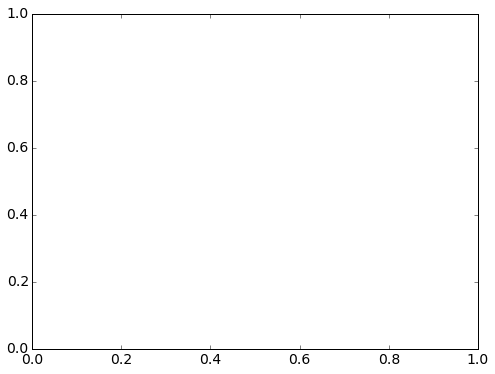

In [207]:
# multiple scatter plots in Pandas
fig, axs = plt.subplots(1, len(feature_cols), sharey=True)
for index, feature in enumerate(feature_cols):
    bikes.plot(kind='scatter', x=feature, y='total', ax=axs[index], figsize=(16, 3))

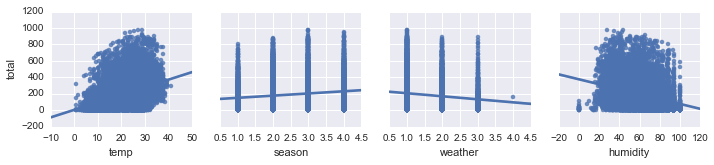

In [89]:
# multiple scatter plots in Seaborn
sns.pairplot(bikes, x_vars=feature_cols, y_vars='total', kind='reg')

Are you seeing anything that you did not expect?

In [208]:
# cross-tabulation of season and month
pd.crosstab(bikes.season, bikes.index.month)

col_0,1,2,3,4,5,6,7,8,9,10,11,12
season,,,,,,,,,,,,
1,884,901,901,0,0,0,0,0,0,0,0,0
2,0,0,0,909,912,912,0,0,0,0,0,0
3,0,0,0,0,0,0,912,912,909,0,0,0
4,0,0,0,0,0,0,0,0,0,911,911,912


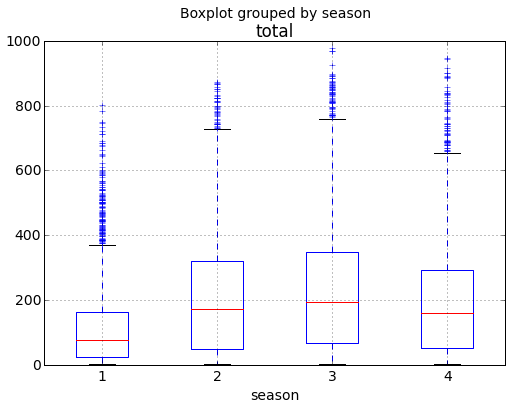

In [209]:
# box plot of rentals, grouped by season
bikes.boxplot(column='total', by='season')

Notably:

- A line can't capture a non-linear relationship.
- There are more rentals in winter than in spring (?)

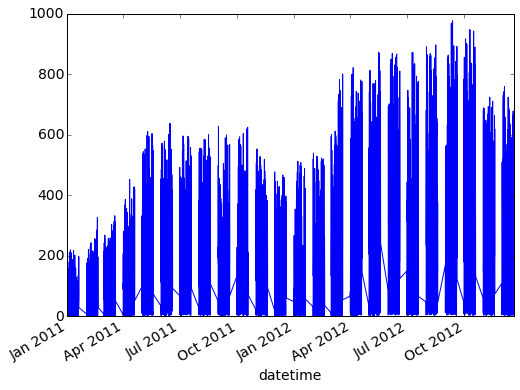

In [36]:
# line plot of rentals
bikes.total.plot()

What does this tell us?

There are more rentals in the winter than the spring, but only because the system is experiencing **overall growth** and the winter months happen to come after the spring months.

In [210]:
# correlation matrix (ranges from 1 to -1)
bikes.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


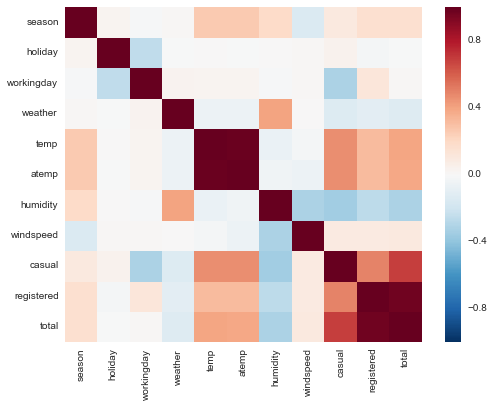

In [94]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(bikes.corr())

What relationships do you notice?

## Adding more features to the model

In [211]:
#Let's try looking at bikes on a daily basis instead of hourly
#Change the dataframe
bikes = bikes.resample('D', how='mean') #the first argument is an abbreviation for the interval your resampling (count is avg hourly)
bikes.head() #Days #20 - 31 were NaN
bikes = bikes.dropna() #Drop NaN rows
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total
datetime,,,,,,,,,,,
2011-01-01,1,0,0,1.583333,14.110833,18.181250,80.583333,10.749871,13.791667,27.250000,41.041667
2011-01-02,1,0,0,1.956522,14.902609,17.686957,69.608696,16.652122,5.695652,29.130435,34.826087
2011-01-03,1,0,1,1.000000,8.050909,9.470227,43.727273,16.636709,5.454545,55.863636,61.318182
2011-01-04,1,0,1,1.043478,8.200000,10.606087,59.043478,10.739809,4.695652,63.217391,67.913043
2011-01-05,1,0,1,1.000000,9.305217,11.463478,43.695652,12.522300,3.565217,66.000000,69.565217


In [183]:
# create a list of features
feature_cols = ['temp', 'season', 'weather', 'humidity']

In [212]:
# create a list of features
feature_cols = ['temp', 'season', 'weather', 'humidity']

# create X and y
X = bikes[feature_cols]
y = bikes.total

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print linreg.intercept_
print linreg.coef_

119.293270498
[  5.57733381  18.49767202 -38.66456041  -0.5205301 ]


In [213]:
# pair the feature names with the coefficients
zip(feature_cols, linreg.coef_)

[('temp', 5.5773338094075804),
 ('season', 18.497672024205492),
 ('weather', -38.664560406135088),
 ('humidity', -0.52053010123889731)]

Interpreting the coefficients:

- Holding all other features fixed, a 1 unit increase in **temperature** is associated with a **rental increase of 7.86 bikes**.
- Holding all other features fixed, a 1 unit increase in **season** is associated with a **rental increase of 22.5 bikes**.
- Holding all other features fixed, a 1 unit increase in **weather** is associated with a **rental increase of 6.67 bikes**.
- Holding all other features fixed, a 1 unit increase in **humidity** is associated with a **rental decrease of 3.12 bikes**.

Does anything look incorrect?

## Feature selection

How do we choose which features to include in the model?

Why not use of **p-values** or **R-squared** for feature selection?

- Linear models rely upon **a lot of assumptions** (such as the features being independent), and if those assumptions are violated, p-values and R-squared are less reliable. Train/test split relies on fewer assumptions.
- Features that are unrelated to the response can still have **significant p-values**.
- Adding features to your model that are unrelated to the response will always **increase the R-squared value**, and adjusted R-squared does not sufficiently account for this.
- p-values and R-squared are **proxies** for our goal of generalization, whereas train/test split and cross-validation attempt to **directly estimate** how well the model will generalize to out-of-sample data.

More generally:

- There are different methodologies that can be used for solving any given data science problem, and this course follows a **machine learning methodology**.
- This course focuses on **general purpose approaches** that can be applied to any model, rather than model-specific approaches.

## Evaluation metrics for regression problems

Evaluation metrics for classification problems, such as **accuracy**, are not useful for regression problems. We need evaluation metrics designed for comparing **continuous values**.

Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [1]:
# example true and predicted response values
true = [10, 7, 5, 5]
pred = [8, 6, 5, 10]

In [214]:
# calculate these metrics by hand!
from sklearn import metrics
import numpy as np
print 'MAE:', metrics.mean_absolute_error(true, pred)
print 'MSE:', metrics.mean_squared_error(true, pred)
print 'RMSE:', np.sqrt(metrics.mean_squared_error(true, pred))

MAE: 2.0
MSE: 7.5
RMSE: 2.73861278753


Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

Here's an additional example, to demonstrate how MSE/RMSE punish larger errors:

In [215]:
# same true values as above
true = [10, 7, 5, 5]

# new set of predicted values
pred = [10, 7, 5, 13]

# MAE is the same as before
print 'MAE:', metrics.mean_absolute_error(true, pred)

# MSE and RMSE are larger than before
print 'MSE:', metrics.mean_squared_error(true, pred)
print 'RMSE:', np.sqrt(metrics.mean_squared_error(true, pred))

MAE: 2.0
MSE: 16.0
RMSE: 4.0


## Comparing models with train/test split and RMSE

In [216]:
# define a function that accepts a list of features and returns testing RMSE
def rmse(feature_cols):
    X = bikes[feature_cols]
    y = bikes.total
    linreg = LinearRegression()
    linreg.fit(X, y)
    y_pred = linreg.predict(X)
    return np.sqrt(metrics.mean_squared_error(y, y_pred))

In [217]:
# compare different sets of features
print rmse(['temp', 'season', 'weather', 'humidity'])
print rmse(['temp', 'season', 'weather'])
print rmse(['temp', 'season', 'humidity'])
# It looks like weather and humidity account for the same variability
# Adding in working day barely reduced the rmse, probably not worth keeping in model

54.5889783177
54.8644042545
56.0511466692


In [218]:
# using these as features is not allowed!
print rmse(['casual', 'registered'])

4.2889220491e-14


In [219]:
#These will be the features in the model
feature_cols = ['temp','season', 'weather','humidity']

#obtaining bikes total based on the temp, season, weather, humidity model
X = bikes[feature_cols]
y = bikes.total
linreg = LinearRegression()
linreg.fit(X, y)
y_pred = linreg.predict(X)

#Mean Absolute Error - MAE
metrics.mean_absolute_error(bikes.total, y_pred)
#MAE with temp, season, weather, humidity = 47.139
#MAE with temp, season, weather = 47.54
#MAE with temp, season, humidity = 47.03
#MAE with season, weather, humidity = 55.546

# Let's look at RMSE for the model with the 4 features
np.sqrt(metrics.mean_squared_error(bikes.total, y_pred))
#RMSE with all 4 features is 54.589

54.588978317686724

## Comparing testing RMSE with null RMSE

Null RMSE is the RMSE that could be achieved by **always predicting the mean response value**. It is a benchmark against which you may want to measure your regression model.

In [156]:
# create a NumPy array with the same shape as y_test
y_null = np.zeros_like(y, dtype=float)

# fill the array with the mean value of y_test
y_null.fill(y.mean())
#y_null

In [221]:
# compute null RMSE
np.sqrt(metrics.mean_squared_error(y, y_null))

77.312361403562832

## Handling categorical features

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding (0/1)

What are the categorical features in our dataset?

- **Ordered categories:** weather (already encoded with sensible numeric values)
- **Unordered categories:** season (needs dummy encoding), holiday (already dummy encoded), workingday (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an **ordered relationship**. Instead, we create **multiple dummy variables:**

In [222]:
# create dummy variables
season_dummies = pd.get_dummies(bikes.season, prefix='season')

# print 5 random rows
season_dummies.sample(n=5, random_state=1)

,season_1.0,season_2.0,season_3.0,season_4.0
datetime,,,,
2011-04-11,0,1,0,0
2011-08-14,0,0,1,0
2012-05-19,0,1,0,0
2012-02-04,1,0,0,0
2011-12-15,0,0,0,1


However, we actually only need **three dummy variables (not four)**, and thus we'll drop the first dummy variable.

Why? Because three dummies captures all of the "information" about the season feature, and implicitly defines spring (season 1) as the **baseline level:**

In [223]:
# drop the first column
season_dummies.drop(season_dummies.columns[0], axis=1, inplace=True)

# print 5 random rows
season_dummies.sample(n=5, random_state=1)

,season_2.0,season_3.0,season_4.0
datetime,,,
2011-04-11,1,0,0
2011-08-14,0,1,0
2012-05-19,1,0,0
2012-02-04,0,0,0
2011-12-15,0,0,1


In general, if you have a categorical feature with **k possible values**, you create **k-1 dummy variables**.

If that's confusing, think about why we only need one dummy variable for holiday, not two dummy variables (holiday_yes and holiday_no).

In [224]:
# concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns)
bikes = pd.concat([bikes, season_dummies], axis=1)

# print 5 random rows
bikes.sample(n=5, random_state=1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,season_2.0,season_3.0,season_4.0
datetime,,,,,,,,,,,,,,
2011-04-11,2,0,1,1.521739,24.421739,28.260870,71.695652,21.739752,37.173913,108.391304,145.565217,1,0,0
2011-08-14,3,0,0,1.916667,27.743333,31.219375,81.750000,14.916433,55.750000,103.416667,159.166667,0,1,0
2012-05-19,2,0,0,1.000000,24.600000,28.345417,45.625000,5.626325,142.083333,203.500000,345.583333,1,0,0
2012-02-04,1,0,0,1.750000,10.830833,13.636250,77.958333,8.167021,16.000000,102.000000,118.000000,0,0,0
2011-12-15,4,0,1,1.791667,17.322500,20.611875,63.416667,17.958792,7.541667,147.000000,154.541667,0,0,1


In [225]:
# include dummy variables for season in the model
feature_cols = ['temp', 'season_2.0', 'season_3.0', 'season_4.0', 'humidity']
X = bikes[feature_cols]
y = bikes.total
linreg = LinearRegression()
linreg.fit(X, y)
zip(feature_cols, linreg.coef_)

[('temp', 6.5239009932369498),
 ('season_2.0', 38.105600346016274),
 ('season_3.0', 22.55680696014862),
 ('season_4.0', 69.021123944872741),
 ('humidity', -1.3051171370427832)]

How do we interpret the season coefficients? They are **measured against the baseline (spring)**:

- Holding all other features fixed, **summer** is associated with a **rental decrease of 3.39 bikes** compared to the spring.
- Holding all other features fixed, **fall** is associated with a **rental decrease of 41.7 bikes** compared to the spring.
- Holding all other features fixed, **winter** is associated with a **rental increase of 64.4 bikes** compared to the spring.

Would it matter if we changed which season was defined as the baseline?

- No, it would simply change our **interpretation** of the coefficients.

**Important:** Dummy encoding is relevant for all machine learning models, not just linear regression models.

In [226]:
# compare original season variable with dummy variables
print rmse(['temp', 'season', 'humidity'])
print rmse(['temp', 'season_2.0', 'season_3.0', 'season_4.0', 'humidity'])

56.0511466692
54.6820704708


## Feature engineering

See if you can create the following features:

- **hour:** as a single numeric feature (0 through 23)
- **hour:** as a categorical feature (use 23 dummy variables)
- **daytime:** as a single categorical feature (daytime=1 from 7am to 8pm, and daytime=0 otherwise)

Then, try using each of the three features (on its own) with `rmse` to see which one performs the best!

In [259]:
# hour as a numeric feature
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/bikeshare.csv'
bikes2 = pd.read_csv(url, index_col='datetime', parse_dates=True)
bikes2.rename(columns={'count':'total'}, inplace=True)
bikes2 = bikes2.reset_index()
bikes2['hour'] = bikes2.datetime.dt.hour

#The bikes2 dataframe is a duplicate of the original, with dt hour column added
bikes2.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1,4


In [265]:
# hour as a categorical feature
#creating the 23 dummy variables
hour_dummies = pd.get_dummies(bikes2.hour, prefix='hour')
#concatenate the dummy variables
bikes2= pd.concat([bikes2, hour_dummies], axis=1)
bikes2.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,...,0,0,0,0,0,0,0,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,...,0,0,0,0,0,0,0,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,...,0,0,0,0,0,0,0,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,...,0,0,0,0,0,0,0,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,...,0,0,0,0,0,0,0,0,0,0


In [269]:
# daytime as a categorical feature
# daytime is 7 am until 8 pm = 1, otherwise 0
bikes2.columns
#for row in bikes2:
#    if row[20:34] == 1:
#        bikes2['daytime'] = 1

Index([u'datetime', u'season', u'holiday', u'workingday', u'weather', u'temp',
       u'atemp', u'humidity', u'windspeed', u'casual', u'registered', u'total',
       u'hour', u'hour_0', u'hour_1', u'hour_2', u'hour_3', u'hour_4',
       u'hour_5', u'hour_6', u'hour_7', u'hour_8', u'hour_9', u'hour_10',
       u'hour_11', u'hour_12', u'hour_13', u'hour_14', u'hour_15', u'hour_16',
       u'hour_17', u'hour_18', u'hour_19', u'hour_20', u'hour_21', u'hour_22',
       u'hour_23', u'hour_0', u'hour_1', u'hour_2', u'hour_3', u'hour_4',
       u'hour_5', u'hour_6', u'hour_7', u'hour_8', u'hour_9', u'hour_10',
       u'hour_11', u'hour_12', u'hour_13', u'hour_14', u'hour_15', u'hour_16',
       u'hour_17', u'hour_18', u'hour_19', u'hour_20', u'hour_21', u'hour_22',
       u'hour_23'],
      dtype='object')

In [260]:
#print rmse(['hour'])
#print rmse(bikes.columns[bikes.columns.str.startswith('hour_')])
#print rmse(['daytime'])

## Comparing linear regression with other models

Advantages of linear regression:

- Simple to explain
- Highly interpretable
- Model training and prediction are fast
- No tuning is required (excluding regularization)
- Features don't need scaling
- Can perform well with a small number of observations
- Well-understood

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response
- Performance is (generally) not competitive with the best supervised learning methods due to high bias
- Can't automatically learn feature interactions